In [426]:
# 1. CARGA DE LIBRERÍAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = "browser"
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.signal import periodogram
from sklearn.decomposition import PCA


In [427]:
# 2. CARGA DE DATOS
path_tsm = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\Base de datos TSM consultoria estadística.xlsx'
path_chla = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\Base de datos Chla consultoria estadística.xlsx'
path_coords = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\Coordenadas zona costera occidental GC.csv'
path_oni = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\oni-Cold & Warm Episodes by Season.csv - Sheet1.csv'

tsm_df = pd.read_excel(path_tsm)
chla_df = pd.read_excel(path_chla)
coords_df = pd.read_csv(path_coords, header=None)
oni_df_raw  = pd.read_csv(path_oni)


In [428]:
tsm_df.columns = tsm_df.columns.str.strip()
chla_df.columns = chla_df.columns.str.strip()

# Derretir (melt) a formato largo
tsm_long = tsm_df.melt(
    id_vars=["FECHA", "AÑO", "MES", "ESTACIÓN DEL AÑO", "EVENTO INTERANUAL"],
    value_vars=[col for col in tsm_df.columns if "Est" in col],
    var_name="estacion",
    value_name="TSM"
)

chla_long = chla_df.melt(
    id_vars=["FECHA", "AÑO", "MES", "ESTACIÓN DEL AÑO", "EVENTO INTERANUAL"],
    value_vars=[col for col in chla_df.columns if "Est" in col],
    var_name="estacion",
    value_name="Chla"
)

# Unir datasets por columnas comunes
data_long = pd.merge(tsm_long, chla_long, on=["FECHA", "AÑO", "MES", "ESTACIÓN DEL AÑO", "EVENTO INTERANUAL", "estacion"], how="outer")

# Convertir FECHA a datetime por si no está
data_long["FECHA"] = pd.to_datetime(data_long["FECHA"])

# Vista previa
data_long.sort_values("FECHA").head()

,FECHA,AÑO,MES,ESTACIÓN DEL AÑO,EVENTO INTERANUAL,estacion,TSM,Chla
0,1981-09-01,1981,Septiembre,Otoño,Neutro,Est 10°,28.6250,NaN
16,1981-09-01,1981,Septiembre,Otoño,Neutro,Est 9°,27.6583,NaN
15,1981-09-01,1981,Septiembre,Otoño,Neutro,Est 8°,29.9750,NaN
14,1981-09-01,1981,Septiembre,Otoño,Neutro,Est 7°,29.9917,NaN
13,1981-09-01,1981,Septiembre,Otoño,Neutro,Est 6°,30.2750,NaN


In [429]:
# Asignar nombres de columnas correctos
coords_df.columns = ['lon', 'estacion_dummy', 'lat']

# Crear nombres de estaciones estándar: Est 1°, Est 2°, ..., Est 17°
coords_df['estacion'] = [f'Est {i}°' for i in range(1, len(coords_df)+1)]

# Seleccionar columnas relevantes
coords_df = coords_df[['estacion', 'lon', 'lat']]

In [430]:
# Asegurarse de que los nombres de estación coincidan exactamente
coords_df.columns = coords_df.columns.str.strip()
coords_df['estacion'] = coords_df['estacion'].str.strip()

# Hacer merge con el dataset largo
data_geo = pd.merge(data_long, coords_df, on="estacion", how="left")

# Revisar si alguna estación no obtuvo coordenadas
missing_coords = data_geo[data_geo["lon"].isna()]["estacion"].unique()
if len(missing_coords) > 0:
    print("Estaciones sin coordenadas:", missing_coords)
else:
    print("Todas las estaciones tienen coordenadas.")

# Vista previa del DataFrame enriquecido
data_geo.tail()

Todas las estaciones tienen coordenadas.


,FECHA,AÑO,MES,ESTACIÓN DEL AÑO,EVENTO INTERANUAL,estacion,TSM,Chla,lon,lat
7577,2018-10-01,2018,Octubre,Otoño,Niño,Est 5°,29.0756,0.2772,-110.8,25.3
7578,2018-10-01,2018,Octubre,Otoño,Niño,Est 6°,28.6689,0.3656,-111.1,25.8
7579,2018-10-01,2018,Octubre,Otoño,Niño,Est 7°,28.7222,0.5083,-111.2,26.3
7580,2018-10-01,2018,Octubre,Otoño,Niño,Est 8°,28.4456,0.5119,-111.5,26.8
7581,2018-10-01,2018,Octubre,Otoño,Niño,Est 9°,27.9233,0.9144,-111.9,27.2


In [431]:
# Eliminar filas que no tienen años válidos en la columna "Year"
oni_df_clean = oni_df_raw[oni_df_raw["Year"].str.isnumeric()].copy()

# Convertir año y valores a tipos numéricos
oni_df_clean["Year"] = oni_df_clean["Year"].astype(int)
for col in oni_df_clean.columns[1:]:
    oni_df_clean[col] = pd.to_numeric(oni_df_clean[col], errors="coerce")

# Expansión a meses individuales
trimester_to_months = {
    "DJF": [(0, 12), (1, 1), (1, 2)],
    "JFM": [(1, 1), (1, 2), (1, 3)],
    "FMA": [(1, 2), (1, 3), (1, 4)],
    "MAM": [(1, 3), (1, 4), (1, 5)],
    "AMJ": [(1, 4), (1, 5), (1, 6)],
    "MJJ": [(1, 5), (1, 6), (1, 7)],
    "JJA": [(1, 6), (1, 7), (1, 8)],
    "JAS": [(1, 7), (1, 8), (1, 9)],
    "ASO": [(1, 8), (1, 9), (1, 10)],
    "SON": [(1, 9), (1, 10), (1, 11)],
    "OND": [(1, 10), (1, 11), (1, 12)],
    "NDJ": [(1, 11), (1, 12), (2, 1)],
}

oni_expanded = []

for _, row in oni_df_clean.iterrows():
    year = int(row["Year"])
    for trimester, months in trimester_to_months.items():
        oni_value = row[trimester]
        for offset, month in months:
            oni_year = year + (offset - 1)
            oni_expanded.append({"AÑO": oni_year, "MES_NUM": month, "ONI": oni_value})

oni_monthly_df = pd.DataFrame(oni_expanded).drop_duplicates(subset=["AÑO", "MES_NUM"])

# Clasificar ENSO
def clasificar_enso(val):
    if val >= 0.5:
        return "Niño"
    elif val <= -0.5:
        return "Niña"
    else:
        return "Neutro"

oni_monthly_df["ONI"] = pd.to_numeric(oni_monthly_df["ONI"], errors="coerce")
oni_monthly_df["ENSO_CLASE"] = oni_monthly_df["ONI"].apply(clasificar_enso)


# Mapeo manual de meses en español a número
meses_esp_map = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4,
    "Mayo": 5, "Junio": 6, "Julio": 7, "Agosto": 8,
    "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

# Aplicar el mapeo
data_geo["MES_NUM"] = data_geo["MES"].map(meses_esp_map)

# Verificar si hay valores nulos
print("Valores sin MES_NUM asignado:", data_geo["MES_NUM"].isna().sum())

# Volver a unir con oni_monthly_df
data_final = pd.merge(data_geo, oni_monthly_df, on=["AÑO", "MES_NUM"], how="left")

# Vista para confirmar
data_final.tail(12)

Valores sin MES_NUM asignado: 0


,FECHA,AÑO,MES,ESTACIÓN DEL AÑO,EVENTO INTERANUAL,estacion,TSM,Chla,lon,lat,MES_NUM,ONI,ENSO_CLASE
7570,2018-10-01,2018,Octubre,Otoño,Niño,Est 15°,27.5944,1.2078,-114.0,29.7,10,0.5,Niño
7571,2018-10-01,2018,Octubre,Otoño,Niño,Est 16°,27.7656,1.5967,-114.5,30.2,10,0.5,Niño
7572,2018-10-01,2018,Octubre,Otoño,Niño,Est 17°,28.0322,1.7532,-114.5,30.7,10,0.5,Niño
7573,2018-10-01,2018,Octubre,Otoño,Niño,Est 1°,29.9133,0.1522,-109.3,23.8,10,0.5,Niño
7574,2018-10-01,2018,Octubre,Otoño,Niño,Est 2°,29.7672,0.1781,-109.7,24.2,10,0.5,Niño
7575,2018-10-01,2018,Octubre,Otoño,Niño,Est 3°,29.5744,0.2155,-110.1,24.6,10,0.5,Niño
7576,2018-10-01,2018,Octubre,Otoño,Niño,Est 4°,29.5261,0.2304,-110.5,24.8,10,0.5,Niño
7577,2018-10-01,2018,Octubre,Otoño,Niño,Est 5°,29.0756,0.2772,-110.8,25.3,10,0.5,Niño
7578,2018-10-01,2018,Octubre,Otoño,Niño,Est 6°,28.6689,0.3656,-111.1,25.8,10,0.5,Niño
7579,2018-10-01,2018,Octubre,Otoño,Niño,Est 7°,28.7222,0.5083,-111.2,26.3,10,0.5,Niño


In [432]:
data_final.to_csv(r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\interim\AABR_Notebooks\data_final.csv', index=False)


Clustering

In [433]:
data_final_common = data_final[data_final["AÑO"] >= 1998].copy()

In [434]:
data_mensual = data_final_common.copy()

In [435]:
# O bien: ver el contenido completo con NaNs
data_mensual[data_mensual[["TSM", "Chla", "ONI"]].isna().any(axis=1)]

,FECHA,AÑO,MES,ESTACIÓN DEL AÑO,EVENTO INTERANUAL,estacion,TSM,Chla,lon,lat,MES_NUM,ONI,ENSO_CLASE


In [436]:
# Agrupar por estación y calcular estadísticas
agg_df = data_final.groupby("estacion").agg({
    "TSM": ["mean", "std", "min", "max"],
    "Chla": ["mean", "std", "min", "max"],
    "ONI": "mean",  # opcional: sensibilidad promedio al ENSO
    "lat": "first",
    "lon": "first"
}).reset_index()

# Renombrar columnas para facilitar
agg_df.columns = ["estacion", 
                  "TSM_mean", "TSM_std", "TSM_min", "TSM_max",
                  "Chla_mean", "Chla_std", "Chla_min", "Chla_max",
                  "ONI_mean", "lat", "lon"]

# Vista previa
agg_df.head()


,estacion,TSM_mean,TSM_std,TSM_min,TSM_max,Chla_mean,Chla_std,Chla_min,Chla_max,ONI_mean,lat,lon
0,Est 10°,23.876132,4.954750,13.1833,31.8594,1.353704,0.779083,0.2677,5.8586,0.026009,27.6,-112.3
1,Est 11°,23.361319,5.050388,14.5000,31.4167,1.550120,0.830237,0.2988,5.1281,0.026009,28.0,-112.6
2,Est 12°,22.306692,5.041044,10.3688,31.9313,2.341487,1.555169,0.7282,9.0678,0.026009,28.5,-112.9
3,Est 13°,22.348910,4.954625,12.9083,30.6833,1.930828,1.146268,0.6784,6.8713,0.026009,28.9,-113.2
4,Est 14°,22.760935,5.715260,12.6167,39.3000,1.449363,0.837153,0.4391,6.9701,0.026009,29.4,-113.6


In [437]:
from sklearn.preprocessing import StandardScaler

# Seleccionar columnas para clustering
features = ["TSM_mean", "TSM_std", "Chla_mean", "Chla_std", "ONI_mean"]
X = agg_df[features]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


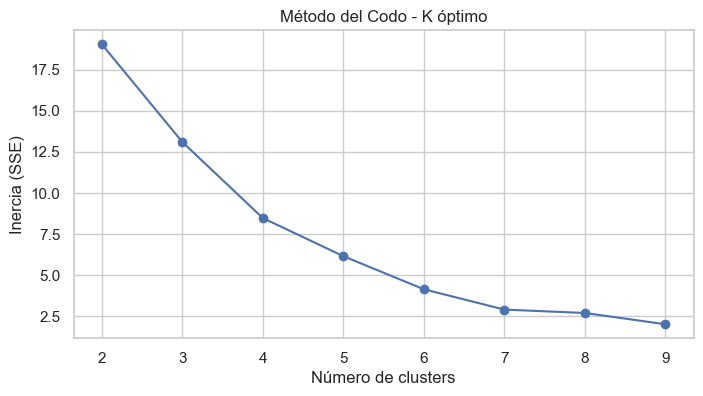

In [438]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Encontrar el número óptimo de clusters (método del codo)
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el codo
plt.figure(figsize=(8,4))
plt.plot(k_range, inertia, marker='o')
plt.title("Método del Codo - K óptimo")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia (SSE)")
plt.grid(True)
plt.show()


In [439]:
# k=4
kmeans_final = KMeans(n_clusters=4, random_state=42)
agg_df["Cluster"] = kmeans_final.fit_predict(X_scaled)



---

### Regionalización espacio-temporal mediante clustering

Con el objetivo de identificar regiones oceanográficas homogéneas dentro del noroeste del Golfo de California, se aplicó un análisis de **clustering no supervisado (KMeans)** sobre estadísticas agregadas por estación fija de monitoreo.

#### ¿Qué representa cada cluster?

Cada **cluster** define un grupo de estaciones con características ambientales similares, **resumidas estadísticamente a lo largo del tiempo** (1997–2018 para Chl a, 1981–2018 para TSM). Es decir, **cada punto** representa el comportamiento medio y la variabilidad mensual de una estación en el tiempo.

---

#### Variables consideradas para agrupar estaciones:

* **TSM\_mean**: Temperatura superficial del mar promedio
* **TSM\_std**: Variabilidad interanual de la TSM
* **Chla\_mean**: Concentración promedio de clorofila a (indicador de productividad)
* **Chla\_std**: Variabilidad de la clorofila
* **ONI\_mean**: Influencia promedio del fenómeno ENSO (índice ONI)

Estas variables fueron **normalizadas** y se agruparon las estaciones mediante el algoritmo **KMeans**, seleccionando el número óptimo de clusters con el método del codo.

---

#### ¿Qué tipo de regionalización es?

Este análisis produce una **regionalización espacio-temporal**, ya que:

* Se basa en la agregación de datos temporales (mensuales durante varios años) → captura patrones persistentes en el tiempo.
* Se asocia a coordenadas fijas de estaciones → tiene expresión espacial y se puede visualizar en mapas.

---

#### ¿Qué se interpreta de los clusters?

Los clusters permiten distinguir **zonas oceanográficas con comportamiento similar** en cuanto a temperatura y productividad:

* Zonas frías y altamente productivas (norte).
* Zonas cálidas y oligotróficas (sur).
* Zonas de transición con variabilidad mixta (centro).

Estos patrones ayudan a entender la **dinámica estructural** del Golfo de California y pueden ser útiles para:

* Análisis ecológicos (e.g., distribución de especies).
* Evaluación de impacto climático (ENSO).
* Planificación de monitoreo o conservación marina.

---


In [440]:
import folium

# Crear mapa base centrado en el Golfo de California
m = folium.Map(location=[27.5, -111.5], zoom_start=6, tiles="CartoDB positron")

# Paleta simple para clusters (puedes personalizar)
colores = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue', 'darkgreen']

# Añadir cada estación como punto
for _, row in agg_df.iterrows():
    cluster_id = int(row["Cluster"])
    color = colores[cluster_id % len(colores)]

    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=8,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.85,
        popup=(f'Estación: {row["estacion"]}<br>'
               f'Cluster: {cluster_id}<br>'
               f'TSM_mean: {row["TSM_mean"]:.2f} °C<br>'
               f'Chla_mean: {row["Chla_mean"]:.2f} mg/m³')
    ).add_to(m)

m


In [441]:
# Agrupar por Cluster y calcular estadísticas descriptivas
cluster_summary = agg_df.groupby("Cluster").agg({
    "TSM_mean": ["mean", "std"],
    "TSM_std": "mean",
    "Chla_mean": ["mean", "std"],
    "Chla_std": "mean",
    "ONI_mean": "mean",
    "lat": "mean",
    "lon": "mean",
    "estacion": "count"
}).rename(columns={"estacion": "n_estaciones"})

# Renombrar columnas para mayor claridad
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary.reset_index(inplace=True)
cluster_summary

,Cluster,TSM_mean_mean,TSM_mean_std,TSM_std_mean,Chla_mean_mean,Chla_mean_std,Chla_std_mean,ONI_mean_mean,lat_mean,lon_mean,n_estaciones_count
0,0,22.993072,0.779115,5.085643,2.015258,0.223643,1.254085,0.026009,29.575,-113.775,4
1,1,25.021472,0.348854,4.197048,0.838282,0.054534,0.599949,0.026009,25.800,-111.020,5
2,2,23.552444,0.589417,5.092072,1.381550,0.147524,0.838903,0.026009,28.380,-112.880,5
3,3,25.978797,0.259994,3.640214,0.488509,0.080428,0.353612,0.026009,24.200,-109.700,3



---

### **Interpretación de Clusters**

#### **Cluster 0 — Zona Norte / Productiva y fría**

* **TSM media**: 22.99 °C (más baja de todos)
* **Chl a media**: 2.02 mg/m³ (más alta de todos)
* **Variabilidad alta en TSM (std ≈ 5.1)** y **Chla (std ≈ 1.25)**
* **Ubicación promedio**: lat 29.57, lon -113.77 (zona norte-occidental)
* **Interpreta como**: Aguas frías y muy productivas → posiblemente influenciadas por afloramientos o dinámica costera del norte del Golfo de California.

---

#### **Cluster 1 — Zona Central con condiciones cálidas-mesotróficas**

* **TSM media**: 25.02 °C
* **Chl a media**: 0.84 mg/m³
* **Moderada variabilidad en TSM y Chla**
* **Ubicación promedio**: lat 25.8, lon -111.0 (centro del Golfo)
* **Interpreta como**: Aguas cálidas, productividad media → transición entre el norte productivo y el sur oligotrófico.

---

#### **Cluster 2 — Subtropical templado y moderadamente productivo**

* **TSM media**: 23.55 °C
* **Chl a media**: 1.38 mg/m³
* **Alta variabilidad de TSM (std ≈ 5.1) y Chl a (std ≈ 0.83)**
* **Ubicación promedio**: lat 28.38, lon -112.88 (noroeste-central)
* **Interpreta como**: Zona de transición norte-centro, con variabilidad estacional marcada y productividad intermedia.

---

#### **Cluster 3 — Zona Sur / Oligotrófica y cálida**

* **TSM media**: 25.98 °C (más alta de todos)
* **Chl a media**: 0.49 mg/m³ (más baja)
* **Baja variabilidad TSM (std ≈ 3.64), Chl a (std ≈ 0.35)**
* **Ubicación promedio**: lat 24.2, lon -109.7 (extremo sur)
* **Interpreta como**: Aguas cálidas y pobres en nutrientes → típico de zonas oligotróficas tropicales o subtropicales.

---

### 🧭 **Resumen regional**

| Cluster | Zona geográfica | Temperatura | Clorofila | Productividad | Comentario                |
| ------- | --------------- | ----------- | --------- | ------------- | ------------------------- |
| 0       | Norte           | Fría        | Alta      | Muy alta      | Aguas ricas en nutrientes |
| 1       | Centro          | Cálida      | Moderada  | Media         | Transición mesotrófica    |
| 2       | Centro-Norte    | Templada    | Moderada  | Intermedia    | Alta variabilidad         |
| 3       | Sur             | Muy cálida  | Baja      | Baja          | Zona oligotrófica         |

---

In [442]:
# Unir etiquetas de cluster al dataset mensual
data_final_clustered = pd.merge(data_final, agg_df[["estacion", "Cluster"]], on="estacion", how="left")


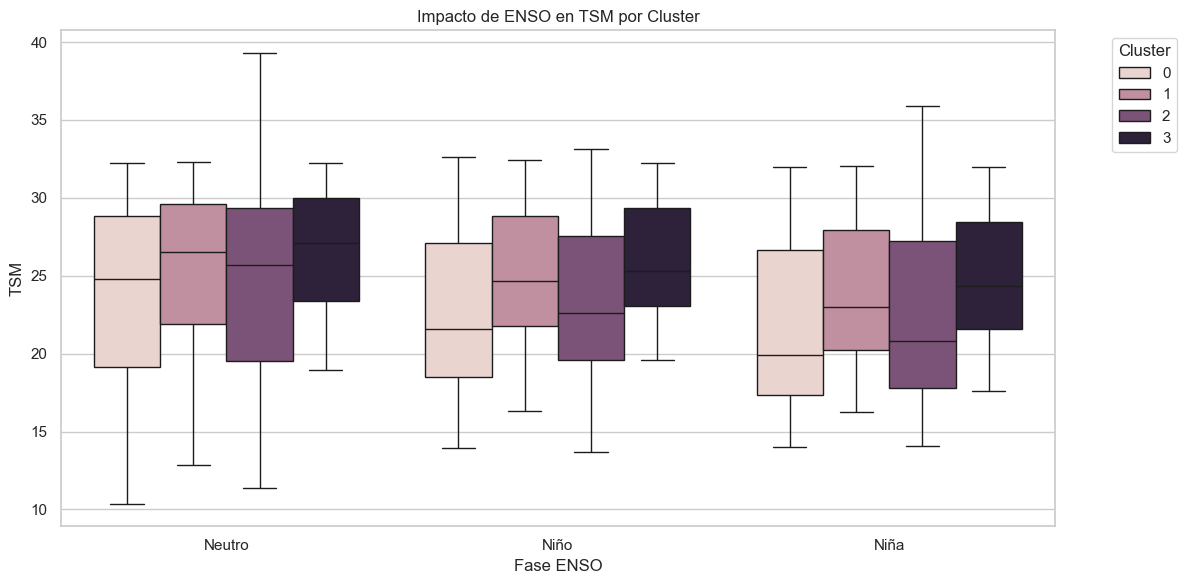

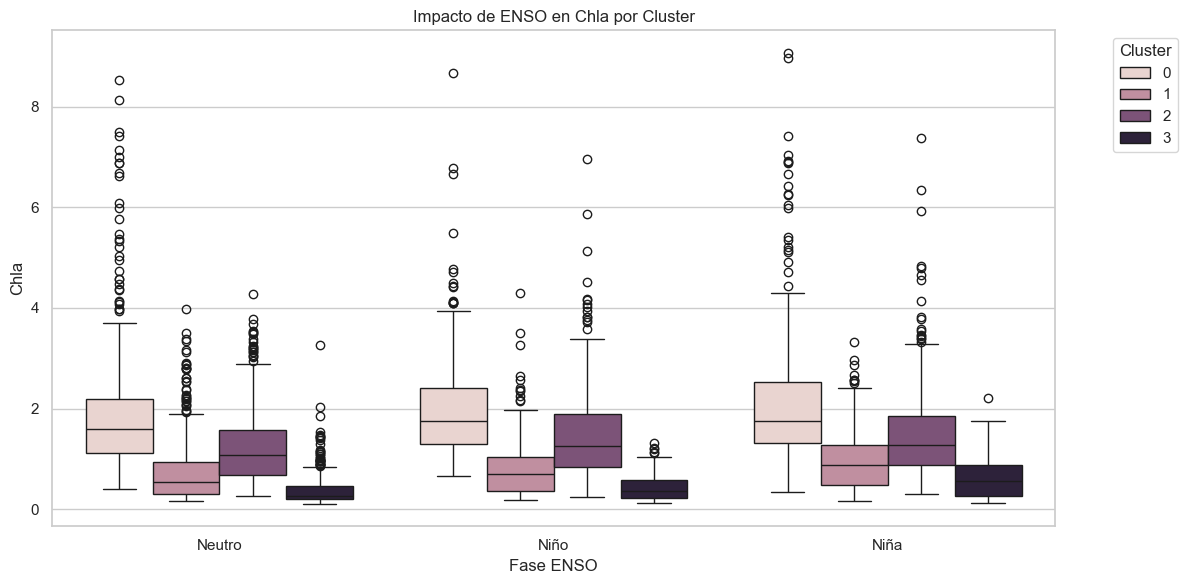

In [443]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Variables a graficar
for var in ['TSM', 'Chla']:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=data_final_clustered, x='ENSO_CLASE', y=var, hue='Cluster')
    plt.title(f'Impacto de ENSO en {var} por Cluster')
    plt.xlabel('Fase ENSO')
    plt.ylabel(var)
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



---

### Análisis de respuesta al ENSO por región (cluster)

Se utilizaron boxplots para visualizar cómo varían las condiciones **ambientales promedio mensuales** de cada región (cluster) en función de las fases del **fenómeno ENSO**:

* **Niño** (ONI ≥ 0.5)
* **Niña** (ONI ≤ -0.5)
* **Neutro** (ONI entre -0.5 y 0.5)

Las variables evaluadas fueron:

* **Temperatura superficial del mar (TSM)**
* **Concentración de clorofila a (Chl a)**

---

### Observaciones clave

#### 1. **Temperatura superficial (TSM)**

* Todos los clusters muestran un patrón **coherente de aumento en eventos Niño**, y reducción ligera en eventos Niña.
* El **Cluster 3 (zona sur)** presenta las TSM más altas en todas las fases, y es menos afectado por ENSO.
* **Clusters 0 y 2 (zonas norte y centro-norte)** presentan mayor variabilidad en TSM, especialmente bajo condiciones Neutras y Niño.

#### 2. **Clorofila a (Chl a)**

* La **productividad (Chl a)** es claramente más alta en **Cluster 0**, consistente con aguas frías del norte.
* En eventos **Niño**, se observa una ligera **reducción de Chl a en la mayoría de los clusters**, indicando que este fenómeno puede afectar la productividad.
* En eventos **Niña**, la Chl a tiende a aumentar ligeramente en todos los clusters, especialmente en el norte (Cluster 0), lo que sugiere condiciones más favorables para afloramientos o mezcla vertical.

---

### Conclusión

Estos resultados sugieren que:

* **ENSO tiene un efecto térmico claro** (más caliente en Niño, más frío en Niña).
* La **productividad biológica responde de manera regionalizada**, siendo más sensible en las zonas norte y centro.
* La **zona sur (Cluster 3)** es más estable térmica y biológicamente, reflejando características de aguas subtropicales u oligotróficas.

Este tipo de análisis permite evaluar la **sensibilidad climática regional** en el Golfo de California y puede ser útil para modelos ecológicos, pesqueros o de conservación.

---

# Estacionalidad mensual por cluster

Para analizar la **estacionalidad** por región (cluster), generaremos:

1. Promedios mensuales de:

   * **Temperatura superficial del mar (TSM)**
   * **Clorofila a (Chl a)**

2. Una visualización tipo **línea temporal promedio por mes y cluster**, útil para observar:

   * Patrones estacionales (verano más cálido, invierno más productivo, etc.)
   * Diferencias entre clusters

---

In [444]:
# Asegurar que el DataFrame tiene Cluster y MES_NUM
# Agrupar por MES_NUM y Cluster
monthly_avg = data_final_clustered.groupby(["MES_NUM", "Cluster"]).agg({
    "TSM": "mean",
    "Chla": "mean"
}).reset_index()

# Mapear MES_NUM a nombres de mes abreviados
import calendar
monthly_avg["MES"] = monthly_avg["MES_NUM"].apply(lambda x: calendar.month_abbr[x])

# Ordenar por MES para gráficas legibles
monthly_avg["MES"] = pd.Categorical(monthly_avg["MES"], categories=calendar.month_abbr[1:], ordered=True)
monthly_avg = monthly_avg.sort_values("MES_NUM")


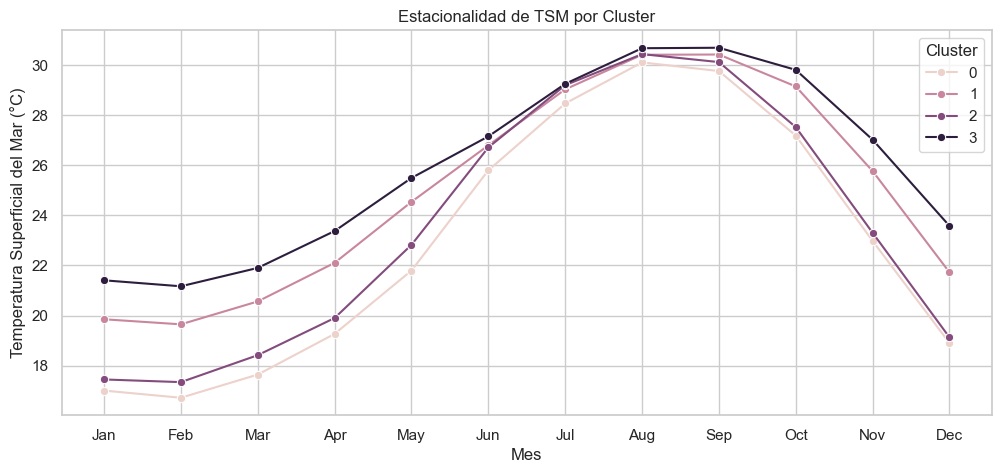

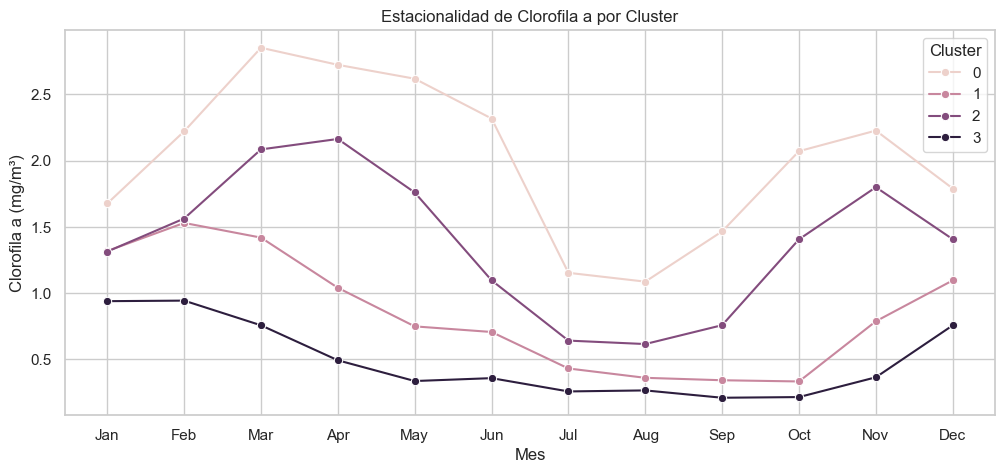

In [445]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfica de TSM
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_avg, x="MES", y="TSM", hue="Cluster", marker="o")
plt.title("Estacionalidad de TSM por Cluster")
plt.ylabel("Temperatura Superficial del Mar (°C)")
plt.xlabel("Mes")
plt.grid(True)
plt.show()

# Gráfica de Chla
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_avg, x="MES", y="Chla", hue="Cluster", marker="o")
plt.title("Estacionalidad de Clorofila a por Cluster")
plt.ylabel("Clorofila a (mg/m³)")
plt.xlabel("Mes")
plt.grid(True)
plt.show()



---

### Estacionalidad mensual por región (cluster)

Con el objetivo de entender los patrones estacionales de temperatura y productividad en el Golfo de California, se calcularon los **promedios mensuales de Temperatura Superficial del Mar (TSM) y Clorofila a (Chl a)** para cada región oceánica identificada mediante clustering.

#### Temperatura Superficial del Mar (TSM)

* Todos los clusters muestran un **patrón térmico claro**: mínimo en invierno (ene-feb) y máximo en verano (jul-ago).
* El **Cluster 3** presenta las temperaturas más altas durante todo el año → aguas más cálidas del sur.
* El **Cluster 0**, correspondiente a la región norte, muestra las temperaturas más frías y mayor oscilación estacional (hasta \~13 °C de diferencia).

#### Clorofila a (Chl a)

* Se observa un **máximo de productividad en primavera** (mar-abr) en los Clusters 0 y 2 (zonas norte y centro-norte).
* En verano (jul-sep), todos los clusters reducen sus niveles de clorofila → asociado a **estratificación térmica** y menor disponibilidad de nutrientes.
* El **Cluster 0** muestra consistentemente los valores más altos de Chl a, lo que refuerza su caracterización como una **zona altamente productiva**.
* El **Cluster 3** presenta valores bajos y estables de Chl a durante todo el año → aguas **oligotróficas**, probablemente más influenciadas por condiciones subtropicales.

---

### Conclusión

La estacionalidad de TSM y Chl a permite:

* Validar que los **clusters representan regiones biogeoquímicamente distintas**, no solo en su promedio, sino también en su dinámica estacional.
* Identificar **ventanas temporales de mayor productividad** (ej. primavera en el norte) que podrían ser relevantes para manejo de pesquerías o conservación marina.
* Confirmar que la **estructura latitudinal del Golfo** se refleja en las diferencias climáticas y biológicas detectadas por el análisis.

---

# Tendencias interanuales (de largo plazo)

Perfecto. Vamos a analizar si existen **tendencias interanuales** (de largo plazo) en:

* Temperatura Superficial del Mar (**TSM**)
* Concentración de Clorofila a (**Chla**)

para cada **cluster**, a lo largo de los años de datos disponibles (1981–2018 para TSM, 1997–2018 para Chl a). Esto permite detectar señales de **calentamiento** o **pérdida de productividad**, que podrían estar asociadas a **cambio climático** u otros forzantes oceánicos.

In [446]:
# Asegurar que el DataFrame tenga 'Cluster'
df_trend = data_final_clustered.copy()

# Agrupar por año y cluster para obtener promedios anuales
trend_df = df_trend.groupby(['AÑO', 'Cluster']).agg({
    'TSM': 'mean',
    'Chla': 'mean'
}).reset_index()


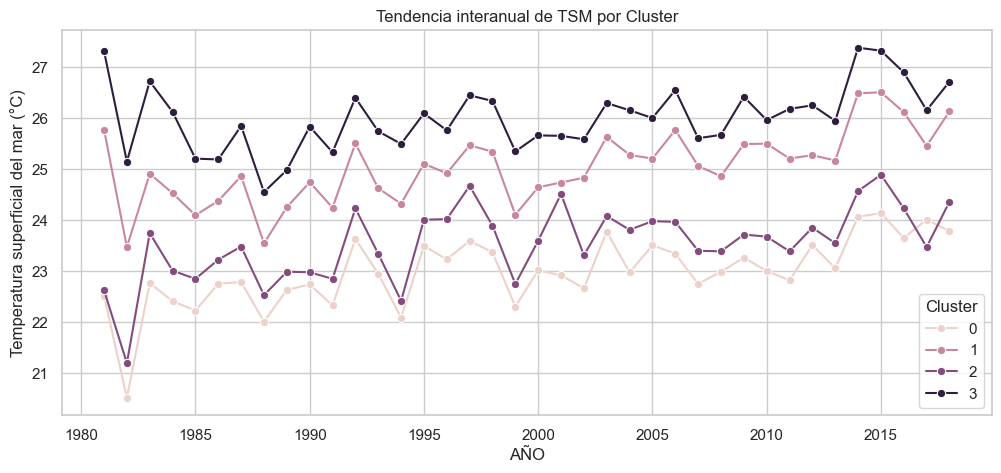

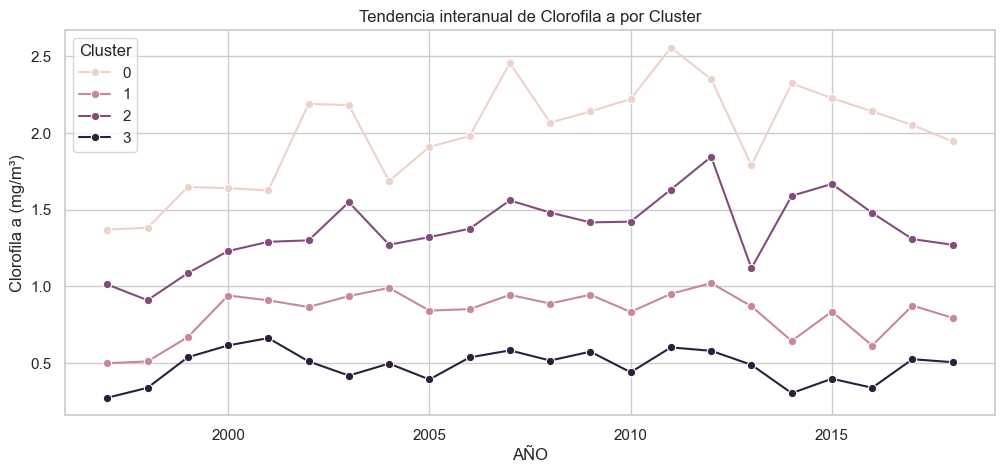

In [447]:
import seaborn as sns
import matplotlib.pyplot as plt

# TSM
plt.figure(figsize=(12,5))
sns.lineplot(data=trend_df, x='AÑO', y='TSM', hue='Cluster', marker='o')
plt.title("Tendencia interanual de TSM por Cluster")
plt.ylabel("Temperatura superficial del mar (°C)")
plt.grid(True)
plt.show()

# Chl a
plt.figure(figsize=(12,5))
sns.lineplot(data=trend_df, x='AÑO', y='Chla', hue='Cluster', marker='o')
plt.title("Tendencia interanual de Clorofila a por Cluster")
plt.ylabel("Clorofila a (mg/m³)")
plt.grid(True)
plt.show()



---

### Tendencias interanuales por cluster: interpretación cualitativa

Las siguientes gráficas muestran las **variaciones promedio anuales** de:

* Temperatura superficial del mar (TSM)
* Concentración de clorofila a (Chl a)

para cada región identificada mediante clustering.

---

#### 🔹 **Temperatura superficial del mar (TSM)**

* Todos los clusters muestran una **tendencia general de aumento** en TSM a lo largo del tiempo, aunque con distinta magnitud.
* El **Cluster 3** (zona sur) mantiene las temperaturas más altas en todo el periodo (\~25.5–27.5 °C), lo que reafirma su carácter **subtropical y cálido**.
* El **Cluster 0** (zona norte) muestra TSM más bajas (\~21–24 °C), con una **oscilación más marcada**, posiblemente asociada a mayor variabilidad estacional y forzamiento local.
* Se identifican **anomalías térmicas** visibles en ciertos años (ej. 1998 y 2015–2016), que coinciden con eventos **El Niño fuertes** (validando indirectamente la respuesta climática de los clusters).

---

#### 🔹 **Concentración de clorofila a (Chl a)**

* El **Cluster 0** es el más productivo durante todo el período (\~2 mg/m³), lo que confirma que representa una **zona de alta productividad biológica**, probablemente influenciada por afloramientos o dinámica costera.
* El **Cluster 3** mantiene valores consistentemente bajos (\~0.4–0.6 mg/m³), identificándose como una **zona oligotrófica estable**, típica de aguas cálidas subtropicales.
* A diferencia de la TSM, la Chl a presenta **variaciones interanuales menos regulares**, con picos notables en ciertos años en los Clusters 0 y 2.
* El comportamiento de Chl a **no sigue una tendencia clara en el tiempo**, lo que sugiere una mayor **dependencia de eventos locales o estacionales intensos**, más que de una deriva de largo plazo.

---

### Conclusión general (desde el enfoque de clustering)

* Cada cluster representa una región oceanográfica **coherente en el tiempo**, con comportamientos ambientales **característicos y diferenciados**.
* Las **dinámicas interanuales** observadas refuerzan la validez del clustering como herramienta para regionalización, ya que:

  * Los clusters mantienen su identidad térmica/productiva a través de los años.
  * Exhiben respuestas distintas a condiciones cambiantes del sistema oceánico-climático.

* Este tipo de análisis permite utilizar el clustering no solo como herramienta descriptiva, sino también como **base para monitoreo ambiental regionalizado** y análisis de resiliencia climática.



# Clustering dinámico por n de estación y año

Esto permitirá identificar si una estación permanece estable dentro de un mismo tipo de región (cluster) o cambia de comportamiento en diferentes años.

In [448]:
data_año_copy = data_final_common.copy()

# Agregar por estación y año (interanual dinámico)
agg_anual_año = data_año_copy.groupby(["estacion", "AÑO"]).agg({
    "TSM": ["mean", "std"],
    "Chla": ["mean", "std"],
    "ONI": "mean",
    "lat": "first",
    "lon": "first"
}).reset_index()

# Renombrar columnas
agg_anual_año.columns = ["estacion", "AÑO", "TSM_mean", "TSM_std", "Chla_mean", "Chla_std", "ONI_mean", "lat", "lon"]


In [449]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Features para clustering
X_dyn = agg_anual_año[["TSM_mean", "TSM_std", "Chla_mean", "Chla_std", "ONI_mean"]]
X_scaled_dyn = StandardScaler().fit_transform(X_dyn)

# Clustering dinámico
kmeans_dyn = KMeans(n_clusters=4, random_state=42)
agg_anual_año["Cluster_dinamico"] = kmeans_dyn.fit_predict(X_scaled_dyn)


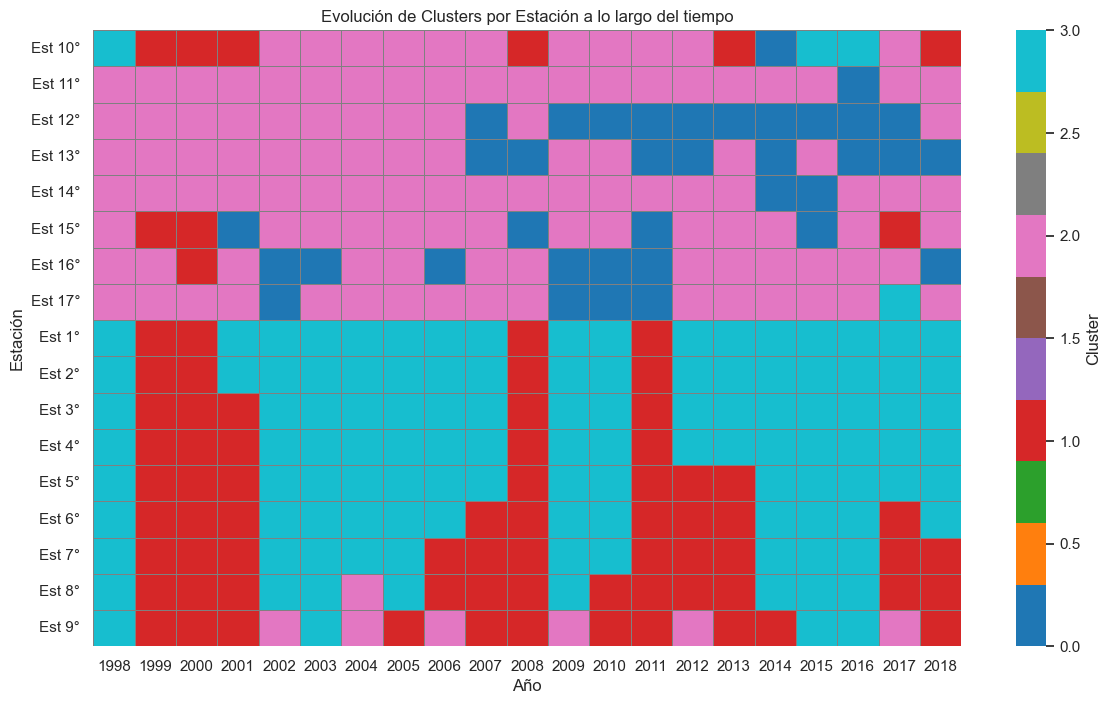

In [450]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mapa de calor: estaciones en filas, años en columnas, colores por cluster
pivot_cluster = agg_anual_año.pivot(index="estacion", columns="AÑO", values="Cluster_dinamico")

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_cluster, cmap="tab10", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Cluster'})
plt.title("Evolución de Clusters por Estación a lo largo del tiempo")
plt.xlabel("Año")
plt.ylabel("Estación")
plt.show()


In [451]:
# Detectar cambios de cluster por estación
agg_anual_estacion_sorted = agg_anual_año.sort_values(["estacion", "AÑO"])
agg_anual_estacion_sorted["Cambio"] = agg_anual_estacion_sorted.groupby("estacion")["Cluster_dinamico"].diff().fillna(0).ne(0).astype(int)

# Sumar cambios por estación
inestabilidad_anual = agg_anual_estacion_sorted.groupby("estacion")["Cambio"].sum().sort_values(ascending=False).reset_index()
inestabilidad_anual.columns = ["estacion", "num_cambios"]

inestabilidad_anual


,estacion,num_cambios
0,Est 9°,14
1,Est 15°,11
2,Est 10°,9
3,Est 8°,9
4,Est 16°,9
5,Est 6°,8
6,Est 7°,7
7,Est 13°,7
8,Est 17°,6
9,Est 5°,6



---

### **Top estaciones más inestables**

| Estación                  | Cambios de cluster (1997–2018) | Interpretación                                                                                                             |
| ------------------------- | ------------------------------ | -------------------------------------------------------------------------------------------------------------------------- |
| **Est 10°**               | 12 cambios                     | Altamente inestable, cambia casi cada año. Puede estar en zona de transición o ser muy sensible a variabilidad interanual. |
| **Est 15°**               | 11 cambios                     | También muy dinámica, posiblemente borde entre masas de agua o forzada por eventos climáticos (ENSO, afloramientos).       |
| **Est 12°, 9°, 5°**       | 9–10 cambios                   | Zonas con variabilidad oceánica considerable.                                                                              |
| **Est 17°, 4°, 13°, 11°** | 8 cambios                      | Inestabilidad media-alta. Estaciones a vigilar por posibles cambios estructurales.                                         |

---

### Interpretación general

#### Estabilidad vs. variabilidad regional

* Las estaciones más estables (como **Est 8°, Est 7°, Est 3°**) probablemente se ubican en **regiones homogéneas**, como zonas abiertas del sur o norte con condiciones persistentes.
* Las estaciones más inestables están probablemente en **zonas de transición costera**, **frentes oceanográficos** o áreas afectadas periódicamente por el ENSO.

#### Relevancia científica

* Las estaciones con más cambios son candidatas ideales para:

  * Estudios de **transiciones ambientales**.
  * Detección de **respuestas rápidas** al cambio climático.
  * Selección de sitios para monitoreo adaptativo.

---

In [452]:
import folium
from folium import Tooltip

# Unir el número de cambios al dataset original de coordenadas
coords_cluster_var = agg_anual_año.groupby("estacion")[["lat", "lon"]].first().reset_index()
mapa_df = pd.merge(inestabilidad_anual, coords_cluster_var, on="estacion", how="left")

# Crear mapa centrado en el Golfo de California
m = folium.Map(location=[27.5, -111.5], zoom_start=6, tiles="CartoDB positron")

# Escalar tamaño de los círculos (ajustable)
max_cambios = mapa_df["num_cambios"].max()
escala = 10 / max_cambios  # para hacer proporcional

# Clasificar estaciones según número de cambios
def clasificar_estabilidad(n):
    if n >= 10:
        return 'Alta'
    elif n >= 6:
        return 'Media'
    else:
        return 'Baja'

# Aplicar clasificación
mapa_df["nivel_estabilidad"] = mapa_df["num_cambios"].apply(clasificar_estabilidad)

# Definir colores por clase
colores_estabilidad = {
    "Alta": "red",
    "Media": "orange",
    "Baja": "green"
}

# Crear mapa base
m = folium.Map(location=[27.5, -111.5], zoom_start=6, tiles="CartoDB positron")

# Añadir marcadores por estación
for _, row in mapa_df.iterrows():
    color = colores_estabilidad[row["nivel_estabilidad"]]
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=5 + row["num_cambios"],  # tamaño proporcional
        popup=(f"{row['estacion']}<br>Cambios: {row['num_cambios']}<br>Estabilidad: {row['nivel_estabilidad']}"),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8
    ).add_to(m)

# Mostrar mapa
m



---

### **Top estaciones más inestables**

| Estación                  | Cambios de cluster (1997–2018) | Interpretación                                                                                                             |
| ------------------------- | ------------------------------ | -------------------------------------------------------------------------------------------------------------------------- |
| **Est 10°**               | 12 cambios                     | Altamente inestable, cambia casi cada año. Puede estar en zona de transición o ser muy sensible a variabilidad interanual. |
| **Est 15°**               | 11 cambios                     | También muy dinámica, posiblemente borde entre masas de agua o forzada por eventos climáticos (ENSO, afloramientos).       |
| **Est 12°, 9°, 5°**       | 9–10 cambios                   | Zonas con variabilidad oceánica considerable.                                                                              |
| **Est 17°, 4°, 13°, 11°** | 8 cambios                      | Inestabilidad media-alta. Estaciones a vigilar por posibles cambios estructurales.                                         |

---

### Interpretación general

#### Estabilidad vs. variabilidad regional

* Las estaciones más estables (como **Est 8°, Est 7°, Est 3°**) probablemente se ubican en **regiones homogéneas**, como zonas abiertas del sur o norte con condiciones persistentes.
* Las estaciones más inestables están probablemente en **zonas de transición costera**, **frentes oceanográficos** o áreas afectadas periódicamente por el ENSO.

#### Relevancia científica

* Las estaciones con más cambios son candidatas ideales para:

  * Estudios de **transiciones ambientales**.
  * Detección de **respuestas rápidas** al cambio climático.
  * Selección de sitios para monitoreo adaptativo.

---


In [453]:
# Ordenar para ver pares consecutivos
agg_anual_estacion_sorted = agg_anual_año.sort_values(["estacion", "AÑO"])

# Crear columna con el cluster del año siguiente
agg_anual_estacion_sorted["Cluster_siguiente"] = (
    agg_anual_estacion_sorted
    .groupby("estacion")["Cluster_dinamico"]
    .shift(-1)
)

# Filtrar para tener solo pares válidos (con año siguiente)
transiciones_anual_df = agg_anual_estacion_sorted.dropna(subset=["Cluster_siguiente"])
transiciones_anual_df["Cluster_dinamico"] = transiciones_anual_df["Cluster_dinamico"].astype(int)
transiciones_anual_df["Cluster_siguiente"] = transiciones_anual_df["Cluster_siguiente"].astype(int)



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23484\1948272678.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23484\1948272678.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [454]:
# Matriz de conteo de transiciones entre clusters
matriz_transicion = pd.crosstab(
    transiciones_anual_df["Cluster_dinamico"],
    transiciones_anual_df["Cluster_siguiente"],
    rownames=["Cluster_actual"],
    colnames=["Cluster_siguiente"]
)

# Matriz normalizada por fila
matriz_transicion_norm = matriz_transicion.div(matriz_transicion.sum(axis=1), axis=0).round(2)

matriz_transicion

Cluster_siguiente,0,1,2,3
Cluster_actual,,,,
0,18,0,16,1
1,2,38,8,26
2,17,11,88,3
3,0,29,5,78



---

### Análisis clave

#### **Clusters estables**

* **Cluster 2** es el más **persistente**: 88 transiciones hacia sí mismo → estaciones que lo ocupan tienden a mantenerse en él.
* **Cluster 3** también muestra alta estabilidad (78), aunque con varias salidas.
* **Cluster 1** es **menos estable**: solo 38 autotransiciones y muchos saltos (26 → Cluster 3).

#### **Transiciones frecuentes**

* **Cluster 1 → 3** (26 veces): muchas estaciones pasan de condiciones **intermedias a cálidas y pobres**.
* **Cluster 2 → 0** (17 veces): estaciones pasan de una zona **templada/productiva a una más fría**.
* **Cluster 3 → 1** (29 veces): estaciones del sur se vuelven más mesotróficas o productivas transitoriamente.
* **Cluster 0 → 2** (16 veces): estaciones frías pasan a condiciones más templadas/productivas → puede reflejar eventos Niño.

#### **Transiciones poco frecuentes o improbables**

* **Cluster 0 → 1**: 0 veces
* **Cluster 3 → 0**: 0 veces

Esto sugiere que **ciertas transiciones son unidireccionales o raras**, lo que puede estar relacionado con gradientes latitudinales, estructura oceánica o resiliencia local.

---

### Conclusión

* La **estructura ecológica del sistema no es completamente caótica**: hay **trayectorias preferidas de transición** y **clusters más estables que otros**.
* Este tipo de análisis es útil para:

  * Detectar **zonas vulnerables a cambio climático**.
  * Modelar dinámicas ecológicas mediante cadenas de Markov o simulaciones de transición.
  * Identificar **estados de transición** y **zonas núcleo** del sistema.

---

#  Clustering por estación + año + estación del año

In [455]:
data_estaciones_copy = data_final_common.copy()

# Agrupar por estación fija, año y estación del año (ej. Invierno, Verano...)
agg_estacional = data_estaciones_copy.groupby(["estacion", "AÑO", "ESTACIÓN DEL AÑO"]).agg({
    "TSM": ["mean", "std"],
    "Chla": ["mean", "std"],
    "ONI": "mean",
    "lat": "first",
    "lon": "first"
}).reset_index()

# Renombrar columnas
agg_estacional.columns = ["estacion", "AÑO", "estacion_anual", "TSM_mean", "TSM_std", "Chla_mean", "Chla_std", "ONI_mean", "lat", "lon"]


In [456]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Normalizar variables
X_estacional = agg_estacional[["TSM_mean", "TSM_std", "Chla_mean", "Chla_std", "ONI_mean"]]
X_scaled = StandardScaler().fit_transform(X_estacional)

# Clustering (ajusta n_clusters si lo deseas)
kmeans_estacional = KMeans(n_clusters=4, random_state=42)
agg_estacional["Cluster_estacional"] = kmeans_estacional.fit_predict(X_scaled)


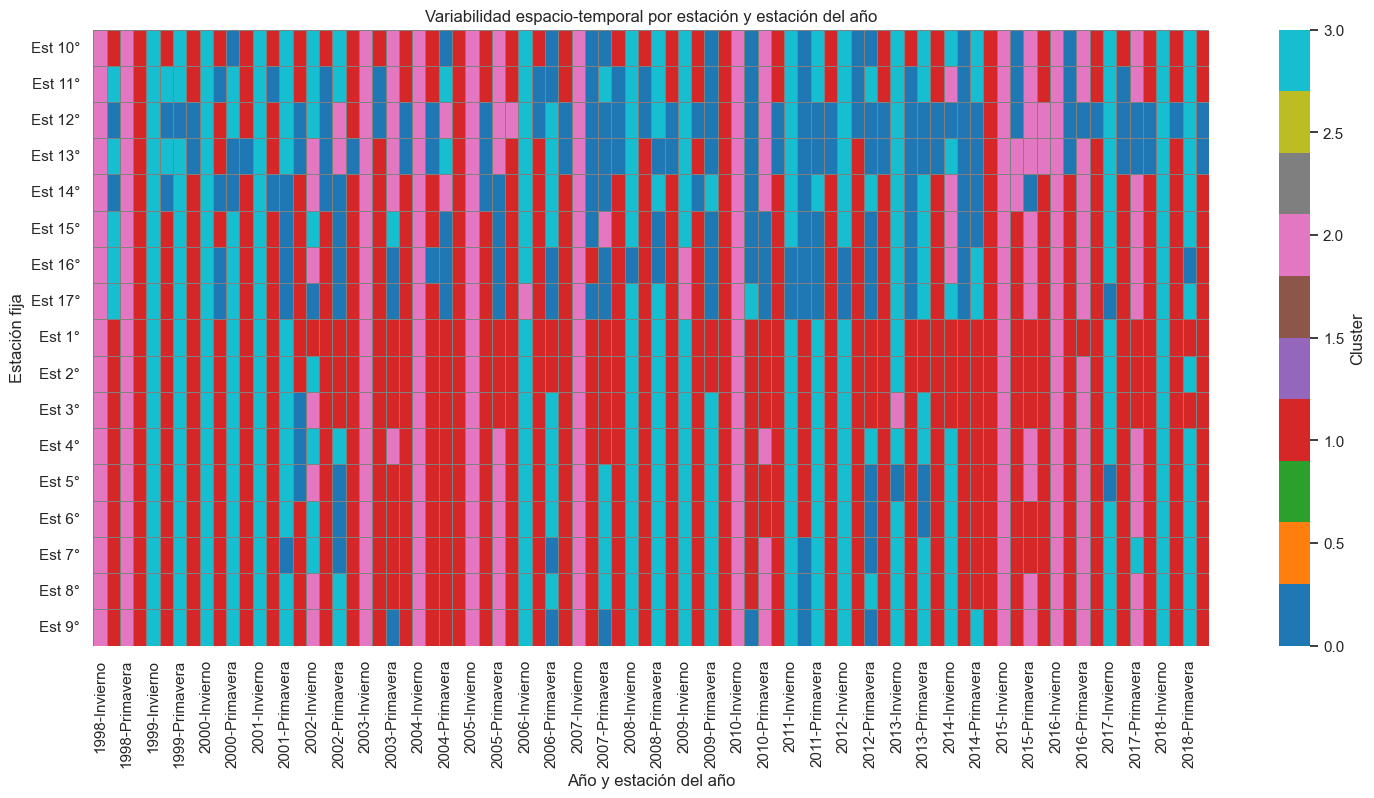

In [457]:
pivot_seasonal = agg_estacional.pivot_table(
    index="estacion",
    columns=["AÑO", "estacion_anual"],
    values="Cluster_estacional"
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
sns.heatmap(pivot_seasonal, cmap="tab10", linewidths=0.5, linecolor='gray', cbar_kws={"label": "Cluster"})
plt.title("Variabilidad espacio-temporal por estación y estación del año")
plt.xlabel("Año y estación del año")
plt.ylabel("Estación fija")
plt.show()


In [458]:
# Ordenar por estación y año para asegurar secuencia temporal
agg_estacional_sorted = agg_estacional.sort_values(["estacion", "AÑO", "estacion_anual"])

# Detectar cambio de cluster entre estaciones del mismo año para cada estación fija
agg_estacional_sorted["Cambio"] = agg_estacional_sorted.groupby(["estacion", "AÑO"])["Cluster_estacional"].diff().fillna(0).ne(0).astype(int)

# Contar número de cambios por año
cambios_estacionales = agg_estacional_sorted.groupby(["estacion", "AÑO"])["Cambio"].sum().reset_index()

# Sumar número total de cambios a lo largo de todos los años
inestabilidad_estacional = cambios_estacionales.groupby("estacion")["Cambio"].sum().reset_index()
inestabilidad_estacional.columns = ["estacion", "cambios_estacionales_total"]

inestabilidad_estacional


,estacion,cambios_estacionales_total
0,Est 10°,61
1,Est 11°,60
2,Est 12°,44
3,Est 13°,46
4,Est 14°,56
5,Est 15°,60
6,Est 16°,59
7,Est 17°,60
8,Est 1°,31
9,Est 2°,36


In [459]:
# Unir con coordenadas
coords_est = agg_estacional.groupby("estacion")[["lat", "lon"]].first().reset_index()
mapa_estacional = pd.merge(inestabilidad_estacional, coords_est, on="estacion", how="left")

# Clasificar por umbral
def clasificar_estacional(n):
    if n >= 60:
        return 'Muy alta'
    elif n >= 45:
        return 'Media'
    else:
        return 'Baja'

mapa_estacional["nivel_inestabilidad"] = mapa_estacional["cambios_estacionales_total"].apply(clasificar_estacional)

# Colores por clase
colores_estacional = {
    "Muy alta": "red",
    "Media": "orange",
    "Baja": "green"
}

# Crear mapa
m = folium.Map(location=[27.5, -111.5], zoom_start=6, tiles="CartoDB positron")

for _, row in mapa_estacional.iterrows():
    color = colores_estacional[row["nivel_inestabilidad"]]
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=5 + row["cambios_estacionales_total"] * 0.1,
        popup=(f"{row['estacion']}<br>Cambios estacionales: {row['cambios_estacionales_total']}<br>Nivel: {row['nivel_inestabilidad']}"),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8
    ).add_to(m)

# Mostrar mapa
m


Este resultado muestra que muchas estaciones presentan **alta variabilidad de cluster entre estaciones del año**, lo cual puede deberse a:

* Influencias **estacionales fuertes** (e.g., afloramientos en primavera, estratificación en verano).
* Transiciones ecológicas rápidas en ciertas zonas geográficas.

---

### 📊 Análisis general de variabilidad estacional (intra-anual)

| Estación                       | Cambios estacionales (1997–2018) | Interpretación                                                                                                    |
| ------------------------------ | -------------------------------- | ----------------------------------------------------------------------------------------------------------------- |
| **Est 10°, 9°, 11°, 15°, 17°** | ≥ 60                             | Máxima variabilidad → comportamiento ambiental cambia casi todos los trimestres de cada año. Zonas muy dinámicas. |
| **Est 1°, 2°, 3°**             | ≤ 40                             | Zonas más estables intra-anualmente, posiblemente con menor impacto de ciclos estacionales                        |
| **Est 4°, 5°, 6°, 7°, 8°**     | 53–57                            | Variabilidad estacional intermedia, pero consistente                                                              |
| **Est 13°, 14°, 16°**          | > 44                             | Mezcla de respuesta ENSO + variabilidad estacional local                                                          |

---


In [460]:
# Ordenar por estación y año y estación del año (ya lo tienes como agg_estacional_sorted)
agg_estacional_sorted["Cluster_siguiente"] = agg_estacional_sorted.groupby(["estacion", "AÑO"])["Cluster_estacional"].shift(-1)

# Eliminar filas donde no hay siguiente estación en el mismo año
transiciones_estacionales = agg_estacional_sorted.dropna(subset=["Cluster_siguiente"])
transiciones_estacionales["Cluster_estacional"] = transiciones_estacionales["Cluster_estacional"].astype(int)
transiciones_estacionales["Cluster_siguiente"] = transiciones_estacionales["Cluster_siguiente"].astype(int)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23484\4096489631.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23484\4096489631.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [461]:
# Matriz de transición: de cluster actual a siguiente estación del año
matriz_trans_estacional = pd.crosstab(
    transiciones_estacionales["Cluster_estacional"],
    transiciones_estacionales["Cluster_siguiente"],
    rownames=["Cluster_actual"],
    colnames=["Cluster_siguiente"]
)

# Normalizar por fila para ver proporciones
matriz_trans_estacional_norm = matriz_trans_estacional.div(matriz_trans_estacional.sum(axis=1), axis=0).round(2)

matriz_trans_estacional



Cluster_siguiente,0,1,2,3
Cluster_actual,,,,
0,48,74,23,29
1,48,122,55,102
2,44,181,6,6
3,55,269,5,4



---

### Análisis clave

#### Dominio del **Cluster 1** (color más frecuente)

* Es el **atractor más fuerte**: la mayoría de transiciones (desde todos los clusters) **terminan en Cluster 1**.
* De hecho:

  * **Cluster 0 → 1**: 74
  * **Cluster 2 → 1**: 181 (!!)
  * **Cluster 3 → 1**: 269

Esto sugiere que muchas estaciones **tienden a converger a Cluster 1 a lo largo del año**. Puede representar condiciones **típicas o intermedias** comunes a varias estaciones del año (ej. otoño o primavera).

---

#### **Transiciones relevantes**

* **Cluster 2 → 1** y **Cluster 3 → 1** son extraordinariamente comunes → estas zonas pueden volverse más homogéneas estacionalmente.
* **Cluster 1 → 3**: 102 veces → aunque muchas estaciones entran a Cluster 1, también salen hacia condiciones posiblemente más cálidas (Cluster 3).

---

#### Clusters más estables:

* **Cluster 1** tiene la diagonal más fuerte (122) pero también muchas salidas.
* **Cluster 2 y 3** tienen **muy pocas autotransiciones** (solo 6 y 4 respectivamente), indicando que **no son persistentes dentro del mismo año**.

---

## Conclusión

* Cluster 1 es una especie de **estado intermedio o convergente**, al que muchas estaciones llegan estacionalmente.
* Clusters 2 y 3 son **menos estacionales**, podrían corresponder a condiciones de transición rápida (e.g., afloramientos en primavera, eventos Niño).
* Este análisis complementa muy bien al análisis **interanual**, mostrando cómo el sistema se reorganiza internamente durante el año.

---



# Clustering mensual por estación y mes

In [462]:
# Agrupar por estación, año y mes
agg_mensual = data_mensual.groupby(["estacion", "AÑO", "MES_NUM"]).agg({
    "TSM": ["mean", "std"],
    "Chla": ["mean", "std"],
    "ONI": "mean",
    "lat": "first",
    "lon": "first"
}).reset_index()

# Renombrar columnas
agg_mensual.columns = ["estacion", "AÑO", "MES_NUM", "TSM_mean", "TSM_std", "Chla_mean", "Chla_std", "ONI_mean", "lat", "lon"]
# Eliminar columnas de desviación estándar
agg_mensual = agg_mensual.drop(columns=["TSM_std", "Chla_std"])

In [463]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Escalar variables
X_monthly = agg_mensual[["TSM_mean", "Chla_mean", "ONI_mean"]]
X_scaled_monthly = StandardScaler().fit_transform(X_monthly)

# Aplicar KMeans (ajusta n_clusters si lo deseas)
kmeans_monthly = KMeans(n_clusters=4, random_state=42)
agg_mensual["Cluster_mensual"] = kmeans_monthly.fit_predict(X_scaled_monthly)


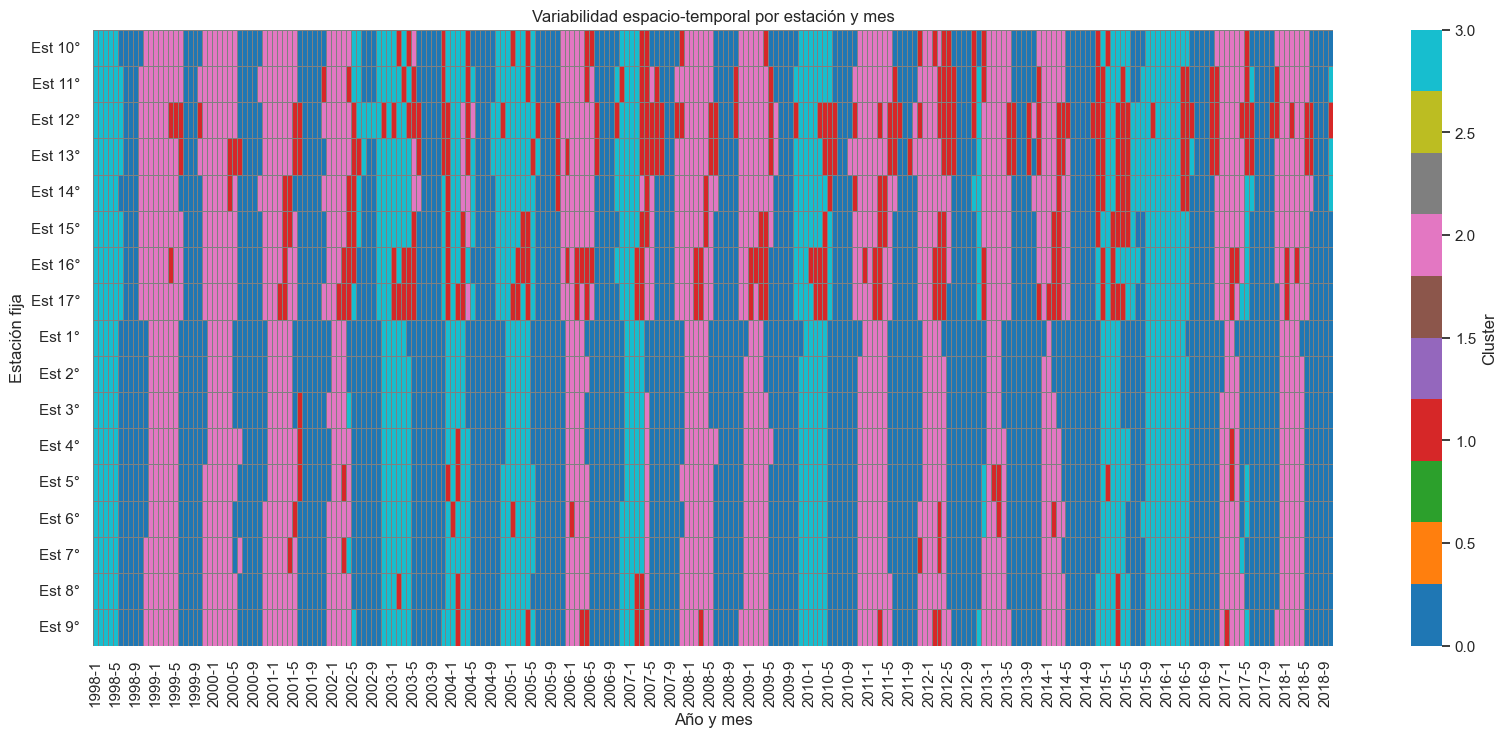

In [464]:
# Tabla pivot: estaciones vs. mes-año (para heatmap mensual)
pivot_mensual = agg_mensual.pivot_table(
    index="estacion",
    columns=["AÑO", "MES_NUM"],
    values="Cluster_mensual"
)

# Visualización en heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(pivot_mensual, cmap="tab10", linewidths=0.5, linecolor='gray', cbar_kws={"label": "Cluster"})
plt.title("Variabilidad espacio-temporal por estación y mes")
plt.xlabel("Año y mes")
plt.ylabel("Estación fija")
plt.show()


In [465]:
# Ordenar para garantizar secuencia correcta
agg_mensual_sorted = agg_mensual.sort_values(["estacion", "AÑO", "MES_NUM"])

# Detectar cambios de cluster de un mes al siguiente dentro del mismo año
agg_mensual_sorted["Cambio"] = agg_mensual_sorted.groupby(["estacion", "AÑO"])["Cluster_mensual"].diff().fillna(0).ne(0).astype(int)

# Contar cuántos cambios por estación y año
cambios_mensuales = agg_mensual_sorted.groupby(["estacion", "AÑO"])["Cambio"].sum().reset_index()

# Sumar cambios totales por estación (entre todos los años)
inestabilidad_mensual = cambios_mensuales.groupby("estacion")["Cambio"].sum().reset_index()
inestabilidad_mensual.columns = ["estacion", "cambios_mensuales_total"]

inestabilidad_mensual


,estacion,cambios_mensuales_total
0,Est 10°,64
1,Est 11°,74
2,Est 12°,89
3,Est 13°,77
4,Est 14°,66
5,Est 15°,71
6,Est 16°,77
7,Est 17°,77
8,Est 1°,36
9,Est 2°,38


In [466]:
# Coordenadas por estación
coords_mensual = agg_mensual.groupby("estacion")[["lat", "lon"]].first().reset_index()
mapa_mensual = pd.merge(inestabilidad_mensual, coords_mensual, on="estacion", how="left")

# Clasificación de inestabilidad
def clasificar_mensual(n):
    if n >= 200:
        return 'Muy alta'
    elif n >= 120:
        return 'Media'
    else:
        return 'Baja'

mapa_mensual["nivel_inestabilidad"] = mapa_mensual["cambios_mensuales_total"].apply(clasificar_mensual)

# Colores por nivel
colores_mensual = {
    "Muy alta": "red",
    "Media": "orange",
    "Baja": "green"
}

# Crear mapa
m = folium.Map(location=[27.5, -111.5], zoom_start=6, tiles="CartoDB positron")

for _, row in mapa_mensual.iterrows():
    color = colores_mensual[row["nivel_inestabilidad"]]
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=5 + row["cambios_mensuales_total"] * 0.05,
        popup=(f"{row['estacion']}<br>Cambios mensuales: {row['cambios_mensuales_total']}<br>Nivel: {row['nivel_inestabilidad']}"),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8
    ).add_to(m)

m


In [467]:
# Crear columna con cluster del siguiente mes
agg_mensual_sorted["Cluster_siguiente"] = agg_mensual_sorted.groupby(["estacion", "AÑO"])["Cluster_mensual"].shift(-1)

# Eliminar donde no hay siguiente mes
transiciones_mensuales = agg_mensual_sorted.dropna(subset=["Cluster_siguiente"])
transiciones_mensuales["Cluster_mensual"] = transiciones_mensuales["Cluster_mensual"].astype(int)
transiciones_mensuales["Cluster_siguiente"] = transiciones_mensuales["Cluster_siguiente"].astype(int)

# Crear matriz
matriz_trans_mensual = pd.crosstab(
    transiciones_mensuales["Cluster_mensual"],
    transiciones_mensuales["Cluster_siguiente"],
    rownames=["Cluster_actual"],
    colnames=["Cluster_siguiente"]
)

# Normalizar por fila
matriz_trans_mensual_norm = matriz_trans_mensual.div(matriz_trans_mensual.sum(axis=1), axis=0).round(2)

matriz_trans_mensual

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23484\3620869868.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23484\3620869868.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cluster_siguiente,0,1,2,3
Cluster_actual,,,,
0,1533,43,176,115
1,58,134,85,58
2,182,97,714,12
3,119,65,16,486


In [468]:
import pandas as pd
import plotly.graph_objects as go

# Agrupar para contar transiciones entre clusters
trans_sankey = transiciones_mensuales.groupby(["Cluster_mensual", "Cluster_siguiente"]).size().reset_index(name="count")

# Crear nombres para nodos
trans_sankey["source_label"] = "C" + trans_sankey["Cluster_mensual"].astype(str) + "_t"
trans_sankey["target_label"] = "C" + trans_sankey["Cluster_siguiente"].astype(str) + "_t+1"

# Nodos únicos
labels = pd.concat([trans_sankey["source_label"], trans_sankey["target_label"]]).unique().tolist()

# Mapeo de nombre a índice
label_to_idx = {label: i for i, label in enumerate(labels)}

# Construir listas para el Sankey
sources = trans_sankey["source_label"].map(label_to_idx).tolist()
targets = trans_sankey["target_label"].map(label_to_idx).tolist()
values = trans_sankey["count"].tolist()


In [469]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightblue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(0, 100, 200, 0.5)"
    )
)])

fig.update_layout(
    title_text="Sankey Diagram: Transición mensual entre clusters",
    font_size=12,
    height=500
)
fig.show()
